In [ ]:
import pandas as pd


final_combined = pd.read_csv("data/final_combined.csv", parse_dates=["timestamp"])
tweets_with_sentiment = pd.read_csv("data/tweets_with_sentiment.csv")

In [ ]:
final_combined.head()

,timestamp,price,tweet_id,handle,ticker,sentiment_label,sentiment_score,top_topic,Technology,Healthcare and Pharmaceuticals,Defense and Aerospace,Financials,Airlines and Travel,Energy,Agriculture,Automotive,minutes_since_tweet
0,2020-05-27 13:40:00,63.373416,1265646238768209920,@SenWarren,JPM,Neutral,0.963891,Technology,0.009989,0.000249,0.000902,0.000512,0.000088,0.008489,0.000305,0.001025,-29.20915
1,2020-05-27 13:41:00,62.264346,1265646238768209920,@SenWarren,JPM,Neutral,0.963891,Technology,0.009989,0.000249,0.000902,0.000512,0.000088,0.008489,0.000305,0.001025,-28.20915
2,2020-05-27 13:42:00,99.650077,1265646238768209920,@SenWarren,JPM,Neutral,0.963891,Technology,0.009989,0.000249,0.000902,0.000512,0.000088,0.008489,0.000305,0.001025,-27.20915
3,2020-05-27 13:43:00,63.437362,1265646238768209920,@SenWarren,JPM,Neutral,0.963891,Technology,0.009989,0.000249,0.000902,0.000512,0.000088,0.008489,0.000305,0.001025,-26.20915
4,2020-05-27 13:44:00,63.378044,1265646238768209920,@SenWarren,JPM,Neutral,0.963891,Technology,0.009989,0.000249,0.000902,0.000512,0.000088,0.008489,0.000305,0.001025,-25.20915


In [ ]:
#merge dfs on tweet_id
merged_df = pd.merge(final_combined, tweets_with_sentiment, how='inner', left_on='tweet_id', right_on='id')
merged_df['timestamp_x'] = pd.to_datetime(merged_df['timestamp_x'])  # stock price timestamp
merged_df['timestamp_y'] = pd.to_datetime(merged_df['timestamp_y'])  # tweet timestamp

In [ ]:
#make timestamps timezone-naive
merged_df['timestamp_y'] = merged_df['timestamp_y'].dt.tz_localize(None)
merged_df['timestamp_x'] = merged_df['timestamp_x'].dt.tz_localize(None)

In [ ]:
import numpy as np

#calculate log returns
if 'log_returns' not in merged_df.columns:
    merged_df['log_returns'] = np.log(merged_df['price'] / merged_df['price'].shift(1))
    merged_df = merged_df.dropna()

tweets_df = merged_df.copy()

In [ ]:
price_data = merged_df[['ticker','timestamp_x','log_returns']].drop_duplicates().sort_values(['ticker','timestamp_x'])
price_groups = dict(tuple(price_data.groupby('ticker')))

In [ ]:
def calculate_volatility(values):
    if len(values) > 0:
        return values.std() * np.sqrt(len(values))
    else:
        return np.nan

In [ ]:
def compute_event_volatility(event, price_groups):
    ticker = event['ticker']
    tweet_time = np.datetime64(event['timestamp_y'])

    group = price_groups.get(ticker)
    if group is None or group.empty:
        return pd.Series({
            'tweet_window_volatility': np.nan,
            'volatility_30min_before': np.nan,
            'volatility_30min_after': np.nan
        })

    #ensure the price group is sorted by time
    times = group['timestamp_x'].values
    log_returns = group['log_returns'].values

    start_tw = tweet_time - np.timedelta64(30, 'm')  # 30 minutes before tweet
    end_tw = tweet_time + np.timedelta64(30, 'm')    # 30 minutes after tweet
    start_pre = tweet_time - np.timedelta64(30, 'm')  # 30 minutes before tweet
    end_pre = tweet_time  # up to tweet_time (not including)
    start_post = tweet_time
    end_post = tweet_time + np.timedelta64(30, 'm')   # 30 minutes after tweet

    # Use searchsorted for fast index lookup
    idx_tw = np.searchsorted(times, np.array([start_tw, end_tw]))
    idx_pre = np.searchsorted(times, np.array([start_pre, end_pre]))
    idx_post = np.searchsorted(times, np.array([start_post, end_post]))

    #slice the log_returns for each window
    window_tw = log_returns[idx_tw[0]: idx_tw[1]]
    window_pre = log_returns[idx_pre[0]: idx_pre[1]]
    window_post = log_returns[idx_post[0]: idx_post[1]]

    vol_tw = calculate_volatility(window_tw)
    vol_pre = calculate_volatility(window_pre)
    vol_post = calculate_volatility(window_post)

    return pd.Series({
        'tweet_window_volatility': vol_tw,
        'volatility_30min_before': vol_pre,
        'volatility_30min_after': vol_post
    })

In [ ]:
unique_events_df = tweets_df.drop_duplicates(subset=['timestamp_y', 'ticker']).copy()

In [ ]:
results_list = []
for idx, event in unique_events_df.iterrows():
    res = compute_event_volatility(event, price_groups)
    results_list.append(res)

results_df = pd.DataFrame(results_list, index=unique_events_df.index)
unique_events_df = unique_events_df.join(results_df)

In [ ]:
print(unique_events_df[['timestamp_y', 'ticker', 'sentiment_label_y',
                          'tweet_window_volatility', 'volatility_30min_before',
                          'volatility_30min_after']].head())

                 timestamp_y ticker sentiment_label_y  \
1    2020-05-27 14:09:12.549    JPM           Neutral   
90   2020-05-27 14:09:12.549      C           Neutral   
180  2020-05-27 14:09:12.549     GS           Neutral   
270  2020-05-27 14:09:12.549    BAC           Neutral   
2611 2020-05-26 20:17:35.640    JPM           Neutral   

      tweet_window_volatility  volatility_30min_before  volatility_30min_after  
1                    0.837024                 0.802840                0.227816  
90                   1.580890                 1.314624                0.870264  
180                  1.701465                 1.671348                0.237549  
270                  7.749019                 5.324696                5.627007  
2611                 0.001399                 0.001399                     NaN  


In [ ]:
avg_vol_by_ticker = unique_events_df.groupby('ticker')[['tweet_window_volatility', 'volatility_30min_before', 'volatility_30min_after']].mean().reset_index()

avg_vol_by_ticker.head()

,ticker,tweet_window_volatility,volatility_30min_before,volatility_30min_after
0,AAL,0.438678,0.469415,0.005576
1,AAPL,0.103784,0.108074,0.001633
2,AMZN,0.508724,0.501780,0.001400
3,BA,1.109972,1.128871,0.023548
4,BAC,3.983966,3.008666,2.684044


In [ ]:
#compute the average tweet window volatility
avg_vol_by_ticker = unique_events_df.groupby('ticker')['tweet_window_volatility'].mean()

unique_events_df['avg_tweet_window_volatility'] = unique_events_df['ticker'].map(avg_vol_by_ticker)


#Calculate the percentage deviation for each event relative to its stock's average
unique_events_df['volatility_pct_deviation'] = (
    (unique_events_df['tweet_window_volatility'] - unique_events_df['avg_tweet_window_volatility'])
    / unique_events_df['avg_tweet_window_volatility']) * 100

print(unique_events_df[['ticker', 'tweet_window_volatility', 'avg_tweet_window_volatility', 'volatility_pct_deviation']].head())


     ticker  tweet_window_volatility  avg_tweet_window_volatility  \
1       JPM                 0.837024                     1.204369   
90        C                 1.580890                     0.632159   
180      GS                 1.701465                     1.246308   
270     BAC                 7.749019                     3.983966   
2611    JPM                 0.001399                     1.204369   

      volatility_pct_deviation  
1                   -30.501060  
90                  150.077750  
180                  36.520411  
270                  94.505133  
2611                -99.883878  


Outlier events (significant volatility changes after tweets):
                   timestamp_y ticker sentiment_label_y  \
7471   2020-04-03 15:38:49.653     GS          Negative   
25202  2019-12-19 18:04:09.238   PINS           Neutral   
38883  2018-05-23 18:11:24.899   AAPL           Neutral   
39892  2018-05-18 07:10:42.514   AAPL           Neutral   
46185  2019-06-19 04:34:45.696   AAPL           Neutral   
...                        ...    ...               ...   
514021 2019-12-12 13:05:14.930   SPCE           Neutral   
515821 2019-11-11 10:40:06.418   SPCE           Neutral   
517904 2019-09-27 09:24:07.665     BA           Neutral   
519265 2019-08-20 08:49:35.482    AAL           Neutral   
550921 2019-04-26 07:32:26.797   TSLA           Neutral   

        volatility_30min_before  volatility_30min_after  volatility_change_pct  
7471                   0.395021                1.287326             225.887724  
25202                  0.000427                0.002586            

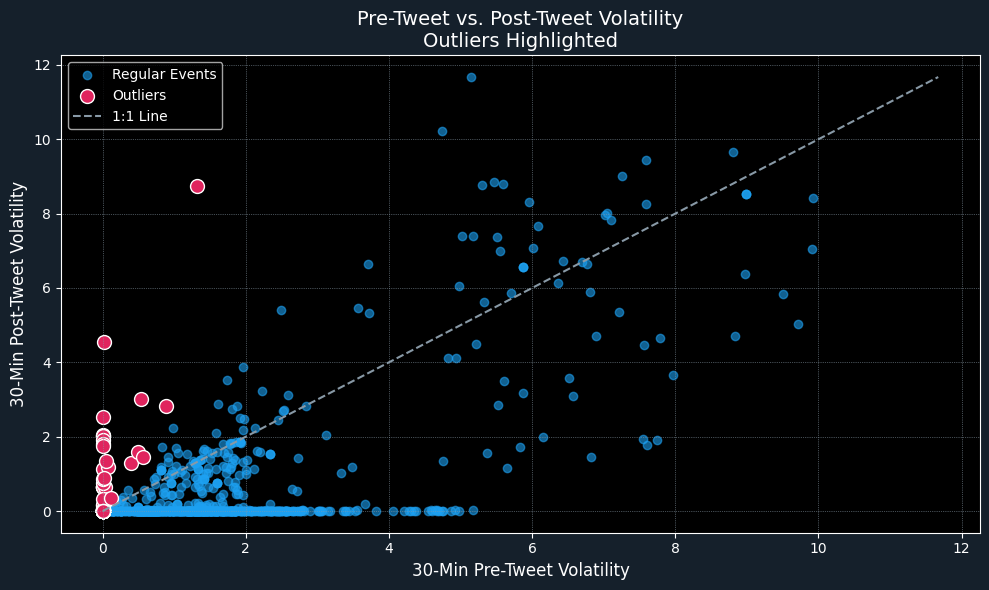

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Twitter Navy Theme Settings
plt.style.use('dark_background')  # overall dark background

TWITTER_NAVY = '#15202B'         # deep Twitter blue
TWITTER_BLUE = '#1DA1F2'         # bright Twitter blue
TWITTER_GRAY = '#8899A6'         # muted gray
OUTLIER_RED = '#E0245E'          # Twitter red/pink for highlights

# Handle division by zero by replacing zeros in volatility_30min_before with np.nan
unique_events_df['volatility_30min_before'] = unique_events_df['volatility_30min_before'].replace(0, np.nan)

# Calculate percentage change in volatility
unique_events_df['volatility_change_pct'] = (
    (unique_events_df['volatility_30min_after'] - unique_events_df['volatility_30min_before']) /
    unique_events_df['volatility_30min_before']
) * 100

# Drop rows with NaN in volatility_change_pct
unique_events_df = unique_events_df.dropna(subset=['volatility_change_pct'])

# Identify outliers using the IQR method
q1 = unique_events_df['volatility_change_pct'].quantile(0.25)
q3 = unique_events_df['volatility_change_pct'].quantile(0.75)
IQR = q3 - q1

lower_bound = q1 - 1.5 * IQR
upper_bound = q3 + 1.5 * IQR

# Flag events outside these bounds as outliers
unique_events_df['is_outlier'] = ((unique_events_df['volatility_change_pct'] < lower_bound) |
                                  (unique_events_df['volatility_change_pct'] > upper_bound))

# Extract outliers
outlier_events = unique_events_df[unique_events_df['is_outlier']]
print("Outlier events (significant volatility changes after tweets):")
print(outlier_events[['timestamp_y', 'ticker', 'sentiment_label_y',
                      'volatility_30min_before', 'volatility_30min_after',
                      'volatility_change_pct']])

# Plotting
plt.figure(figsize=(10, 6), facecolor=TWITTER_NAVY)
plt.scatter(unique_events_df['volatility_30min_before'], unique_events_df['volatility_30min_after'],
            alpha=0.6, label='Regular Events', color=TWITTER_BLUE)
plt.scatter(outlier_events['volatility_30min_before'], outlier_events['volatility_30min_after'],
            color=OUTLIER_RED, edgecolors='white', s=100, label='Outliers')

# 1:1 Reference Line
min_val = unique_events_df[['volatility_30min_before', 'volatility_30min_after']].min().min()
max_val = unique_events_df[['volatility_30min_before', 'volatility_30min_after']].max().max()
plt.plot([min_val, max_val], [min_val, max_val], color=TWITTER_GRAY, linestyle='--', label='1:1 Line')

# Labels and Title
plt.xlabel('30-Min Pre-Tweet Volatility', fontsize=12, color='white')
plt.ylabel('30-Min Post-Tweet Volatility', fontsize=12, color='white')
plt.title('Pre-Tweet vs. Post-Tweet Volatility\nOutliers Highlighted', fontsize=14, color='white')
plt.legend()
plt.grid(True, linestyle=':', linewidth=0.5, color=TWITTER_GRAY)
plt.tight_layout()
plt.show()


In [ ]:
outlier_events = unique_events_df[unique_events_df['is_outlier']].copy()

outlier_list = outlier_events[['tweet_id', 'timestamp_y', 'ticker', 'sentiment_label_y',
                               'volatility_30min_before', 'volatility_30min_after', 'volatility_change_pct']]

In [ ]:
merged_outliers_full = pd.merge(outlier_list, tweets_with_sentiment, left_on='tweet_id', right_on='id', how='left')
#print(merged_outliers_full[['tweet_id', 'timestamp_y', 'ticker', 'sentiment_label_y',
                            #'volatility_30min_before', 'volatility_30min_after',
                            #'volatility_change_pct', 'clean_text', 'handle']].head())



outlier_events = unique_events_df[unique_events_df['is_outlier']]
correlation_columns = ['volatility_change_pct', 'volatility_30min_before', 'volatility_30min_after']

#create a df with only the relevant columns for the outliers
outlier_corr_df = outlier_events[correlation_columns]


In [ ]:
valid_tweets = []

for idx, tweet in merged_outliers_full.iterrows():
    tweet_time = tweet['timestamp_y']
    ticker = tweet['ticker']

    #define the 30-minute window before and after the tweet
    start_time = tweet_time - np.timedelta64(30, 'm')
    end_time = tweet_time + np.timedelta64(30, 'm')

    #filter the data for this ticker within the 30-minute window before and after the tweet
    filtered_data = merged_df[(merged_df['ticker'] == ticker) &
                              (merged_df['timestamp_x'] >= start_time) &
                              (merged_df['timestamp_x'] <= end_time)]


    if len(filtered_data) > 0:  # allow tweets even if the full 1-hour isn't covered
        valid_tweets.append(tweet)


valid_tweets_df = pd.DataFrame(valid_tweets)
valid_tweets_df.head()


,tweet_id,timestamp_y,ticker,sentiment_label_y,volatility_30min_before,volatility_30min_after,volatility_change_pct,id,user_id,handle,clean_text,lang,timestamp,sentiment_label,sentiment_score
0,1246099847234686977,2020-04-03 15:38:49.653,GS,Negative,0.395021,1.287326,225.887724,1246099847234686977,970207298.0,SenWarren,Puerto Rico is still struggling from a debt cr...,en,2020-04-03 15:38:49.653000+00:00,Negative,0.895501
1,1207723306071121920,2019-12-19 18:04:09.238,PINS,Neutral,0.000427,0.002586,505.811869,1207723306071121920,44196397.0,elonmusk,Art in motion https://t.co/sJHTsY4CUG,en,2019-12-19 18:04:09.238000+00:00,Neutral,0.999622
2,999352110645886976,2018-05-23 18:11:24.899,AAPL,Neutral,0.000478,0.001266,164.729907,999352110645886976,44196397.0,elonmusk,RT @ElectrekCo: Tesla (TSLA) could rally as me...,en,2018-05-23 18:11:24.899000+00:00,Neutral,0.753615
3,997373899103862785,2018-05-18 07:10:42.514,AAPL,Neutral,0.000072,0.000590,723.164891,997373899103862785,44196397.0,elonmusk,Some things need no explanation,en,2018-05-18 07:10:42.514000+00:00,Neutral,0.613729
4,1141202636407857152,2019-06-19 04:34:45.696,AAPL,Neutral,0.000064,0.000981,1433.984902,1141202636407857152,44196397.0,elonmusk,@boldasloveally It’s my band name,en,2019-06-19 04:34:45.696000+00:00,Neutral,0.999699


In [ ]:
# Initialize an empty list to store tweets with complete or partial data
valid_tweets = []

# Iterate over each tweet in the merged_outliers_full
for idx, tweet in merged_outliers_full.iterrows():
    tweet_time = tweet['timestamp_y']
    ticker = tweet['ticker']

    # Define the 30-minute window before and after the tweet
    start_time = tweet_time - np.timedelta64(30, 'm')
    end_time = tweet_time + np.timedelta64(30, 'm')

    # Filter the data for this ticker within the 30-minute window before and after the tweet
    filtered_data = merged_df[(merged_df['ticker'] == ticker) &
                              (merged_df['timestamp_x'] >= start_time) &
                              (merged_df['timestamp_x'] <= end_time)]

    # Check if the filtered data has any points within the window (doesn't need to be complete)
    if len(filtered_data) > 0:  # Allow tweets even if the full hour isn't covered
        # Calculate volatility change (assuming it's already calculated)
        tweet['volatility_change'] = (tweet['volatility_30min_after'] - tweet['volatility_30min_before'])
        valid_tweets.append(tweet)

# Create a new DataFrame with the valid tweets only
valid_tweets_df = pd.DataFrame(valid_tweets)

# Sort by volatility change from most volatile to least volatile
sorted_tweets_df = valid_tweets_df.sort_values(by='volatility_change', ascending=False)

# Now, group by 'handle' and get the tweet with the highest volatility change for each handle
top_volatile_tweets = sorted_tweets_df.loc[sorted_tweets_df.groupby('handle')['volatility_change'].idxmax()]

# Display the top volatile tweets per handle
print("Top Volatile Tweets Per Handle:")
print(top_volatile_tweets[['handle', 'ticker', 'volatility_change', 'clean_text', 'timestamp_y']])


Top Volatile Tweets Per Handle:
             handle ticker  volatility_change  \
29        SenWarren    JPM           1.111740   
38         elonmusk   WKHS           4.545514   
77          nntaleb    BAC           7.410662   
9   realDonaldTrump    LVS           0.643212   
79   richardbranson   SPCE           0.897934   

                                           clean_text             timestamp_y  
29  Bristol County families need access to Massach... 2020-12-04 15:58:11.396  
38  Thursday 8pm, Tesla Design Studio https://t.co... 2017-11-15 14:22:50.772  
77  @diomavro @ishirubi @MarinaStavrou9 Yes please... 2020-06-25 12:45:41.742  
9   ....agricultural products from our Great Farme... 2019-05-10 11:22:22.321  
79  Wonderful to be in South Africa to help launch... 2019-11-11 10:40:06.418  


In [ ]:
top_volatile_tweets.head()

,tweet_id,timestamp_y,ticker,sentiment_label_y,volatility_30min_before,volatility_30min_after,volatility_change_pct,id,user_id,handle,clean_text,lang,timestamp,sentiment_label,sentiment_score,volatility_change
29,1334889747009982472,2020-12-04 15:58:11.396,JPM,Neutral,0.078378,1.190118,1418.426328,1334889747009982472,970207298.0,SenWarren,Bristol County families need access to Massach...,en,2020-12-04 15:58:11.396000+00:00,Neutral,0.999589,1.111740
38,930803282829647873,2017-11-15 14:22:50.772,WKHS,Neutral,0.014122,4.559637,32186.810479,930803282829647873,44196397.0,elonmusk,"Thursday 8pm, Tesla Design Studio https://t.co...",en,2017-11-15 14:22:50.772000+00:00,Neutral,0.999975,4.545514
77,1276134470022766593,2020-06-25 12:45:41.742,BAC,Neutral,1.320306,8.730968,561.283618,1276134470022766593,381289719.0,nntaleb,@diomavro @ishirubi @MarinaStavrou9 Yes please...,en,2020-06-25 12:45:41.742000+00:00,Neutral,0.998840,7.410662
9,1126809700304076800,2019-05-10 11:22:22.321,LVS,Neutral,0.004253,0.647465,15122.824752,1126809700304076800,25073877.0,realDonaldTrump,....agricultural products from our Great Farme...,en,2019-05-10 11:22:22.321000+00:00,Neutral,0.999954,0.643212
79,1193840819091976193,2019-11-11 10:40:06.418,SPCE,Neutral,0.565799,1.463733,158.702031,1193840819091976193,8161232.0,richardbranson,Wonderful to be in South Africa to help launch...,en,2019-11-11 10:40:06.418000+00:00,Neutral,0.997849,0.897934


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_volatility_comparison(iloc_number, valid_tweets_df, merged_df):

    tweet = valid_tweets_df.iloc[iloc_number]
    tweet_time = tweet['timestamp_y']
    ticker = tweet['ticker']

    ticker_data = merged_df[merged_df['ticker'] == ticker].copy()
    ticker_data.loc[:, 'timestamp_x'] = pd.to_datetime(ticker_data['timestamp_x'])
    ticker_data = ticker_data.sort_values(by='timestamp_x')

    #define a 30-minute span before and after the tweet
    start_time = tweet_time - np.timedelta64(30, 'm')
    end_time = tweet_time + np.timedelta64(30, 'm')
    time_window_data = ticker_data[(ticker_data['timestamp_x'] >= start_time) &
                                   (ticker_data['timestamp_x'] <= end_time)].copy()

    #calculate log returns volatility
    time_window_data.loc[:, 'log_returns'] = np.log(time_window_data['price'] / time_window_data['price'].shift(1))

    pre_tweet_data = time_window_data[time_window_data['timestamp_x'] < tweet_time]
    post_tweet_data = time_window_data[time_window_data['timestamp_x'] > tweet_time]

    #calculate average volatility for both periods
    pre_tweet_volatility = pre_tweet_data['log_returns'].std() * np.sqrt(len(pre_tweet_data))
    post_tweet_volatility = post_tweet_data['log_returns'].std() * np.sqrt(len(post_tweet_data))




    fig, ax = plt.subplots(figsize=(10, 6), facecolor='#14171A')
    ax.set_facecolor('#14171A')

    #plot pre-tweet volatility in Gray and post-tweet volatility in Light Blue
    ax.plot(pre_tweet_data['timestamp_x'], pre_tweet_data['log_returns'],
            label=f"Pre-Tweet Volatility: {pre_tweet_volatility:.4f}", color='#AAB8C2')
    ax.plot(post_tweet_data['timestamp_x'], post_tweet_data['log_returns'],
            label=f"Post-Tweet Volatility: {post_tweet_volatility:.4f}", color='#1DA1F2')

    #add vertical dashed line (Pink) at the time of the tweet
    ax.axvline(x=tweet_time, color='#E0245E', linestyle='--', label="Tweet Time")

    ax.set_title(f"Pre vs. Post-Tweet Volatility for {ticker}", fontsize=16, fontweight='bold', color='white')
    ax.set_xlabel("Time", fontsize=12, color='white')
    ax.set_ylabel("Volatility (Log Returns)", fontsize=12, color='white')

    tick_positions = time_window_data['timestamp_x'][::5]
    tick_labels = [time.strftime('%I:%M %p') for time in time_window_data['timestamp_x'][::5]]
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels, rotation=45, fontsize=10, color='white')

    ax.tick_params(axis='y', colors='white')
    ax.tick_params(axis='x', colors='white')

    # Set spines (borders) to navy
    for spine in ax.spines.values():
        spine.set_color('#14171A')

    ax.grid(True, color='#657786', linestyle='-', linewidth=0.5)

    leg = ax.legend(loc="upper left", fontsize=10, frameon=False)
    for text in leg.get_texts():
        text.set_color("white")

    plt.tight_layout()
    plt.show()



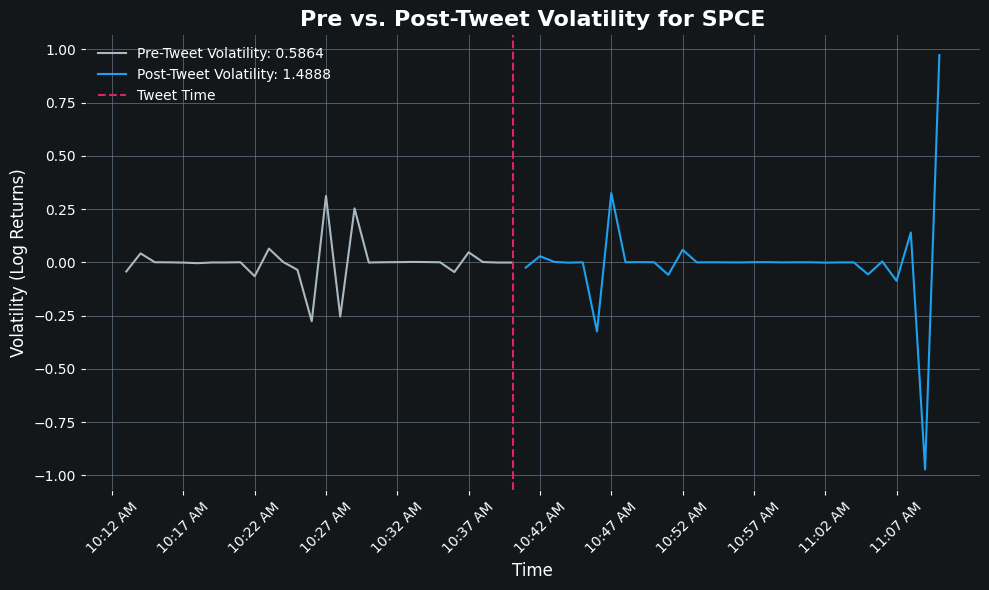

In [ ]:
#plot_volatility_comparison(25, valid_tweets_df, merged_df)
#plot_volatility_comparison(17, valid_tweets_df, merged_df)
#plot_volatility_comparison(77, valid_tweets_df, merged_df)
#plot_volatility_comparison(9, valid_tweets_df, merged_df)
plot_volatility_comparison(79, valid_tweets_df, merged_df)